Merge the datasets

In [9]:
import pandas as pd
import numpy as np


# Load datasets
eps = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/av_eps_quarterly.csv")
margins = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/av_income_quarterly_margins.csv")

In [10]:
# Clean and standardise dates
eps["fiscalDateEnding"] = pd.to_datetime(eps["fiscalDateEnding"])
margins["fiscalDateEnding"] = pd.to_datetime(margins["fiscalDateEnding"])

In [11]:
# Clean numeric fields
numeric_cols = ["reportedEPS", "estimatedEPS", "surprise", "surprisePercentage"]
for col in numeric_cols:
    eps[col] = pd.to_numeric(eps[col], errors="coerce")

margin_numeric_cols = [
    "totalRevenue", "grossProfit", "operatingIncome", "netIncome",
    "grossMargin", "operatingMargin", "netMargin"
]
for col in margin_numeric_cols:
    margins[col] = pd.to_numeric(margins[col], errors="coerce")

In [12]:
# Merge datasets
df = pd.merge(
    eps,
    margins,
    on=["symbol", "fiscalDateEnding"],
    how="inner"   # inner join ensures only matching quarters
)

In [13]:
# Create derived variables

# EPS surprise direction
df["surpriseDirection"] = np.where(df["surprise"] > 0, "positive",
                           np.where(df["surprise"] < 0, "negative", "zero"))

# Surprise magnitude buckets
def bucket_surprise(pct):
    if pd.isna(pct):
        return "missing"
    if abs(pct) < 3:
        return "small"
    elif abs(pct) < 10:
        return "medium"
    else:
        return "large"

df["surpriseBucket"] = df["surprisePercentage"].apply(bucket_surprise)

# Sort for lag calculations
df = df.sort_values(["symbol", "fiscalDateEnding"])

# Margin changes (QoQ)
df["grossMargin_change"] = df.groupby("symbol")["grossMargin"].diff()
df["operatingMargin_change"] = df.groupby("symbol")["operatingMargin"].diff()
df["netMargin_change"] = df.groupby("symbol")["netMargin"].diff()

# Revenue YoY growth 
df["revenue_yoy_growth"] = df.groupby("symbol")["totalRevenue"].pct_change(4)

In [14]:
# Final tidy-up
df = df.reset_index(drop=True)

print(df.head())
print(df.info())

  fiscalDateEnding reportedDate  reportedEPS  estimatedEPS  surprise  \
0       2005-09-30   2005-10-11         0.01          0.01       0.0   
1       2005-12-31   2006-01-18         0.02          0.02       0.0   
2       2006-03-31   2006-04-19         0.02          0.02       0.0   
3       2006-06-30   2006-07-19         0.02          0.02       0.0   
4       2006-09-30   2006-10-18         0.02          0.02       0.0   

   surprisePercentage   reportTime symbol  totalRevenue  grossProfit  ...  \
0                 0.0  post-market   AAPL    3678000000   1035000000  ...   
1                 0.0  post-market   AAPL    5749000000   1564000000  ...   
2                 0.0  post-market   AAPL    4359000000   1297000000  ...   
3                 0.0  post-market   AAPL    4370000000   1325000000  ...   
4                 0.0  post-market   AAPL    4370000000   1412000000  ...   

   netIncome  grossMargin  operatingMargin  netMargin  surpriseDirection  \
0  430000000     0.281403   

Plot financial-metric charts

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")

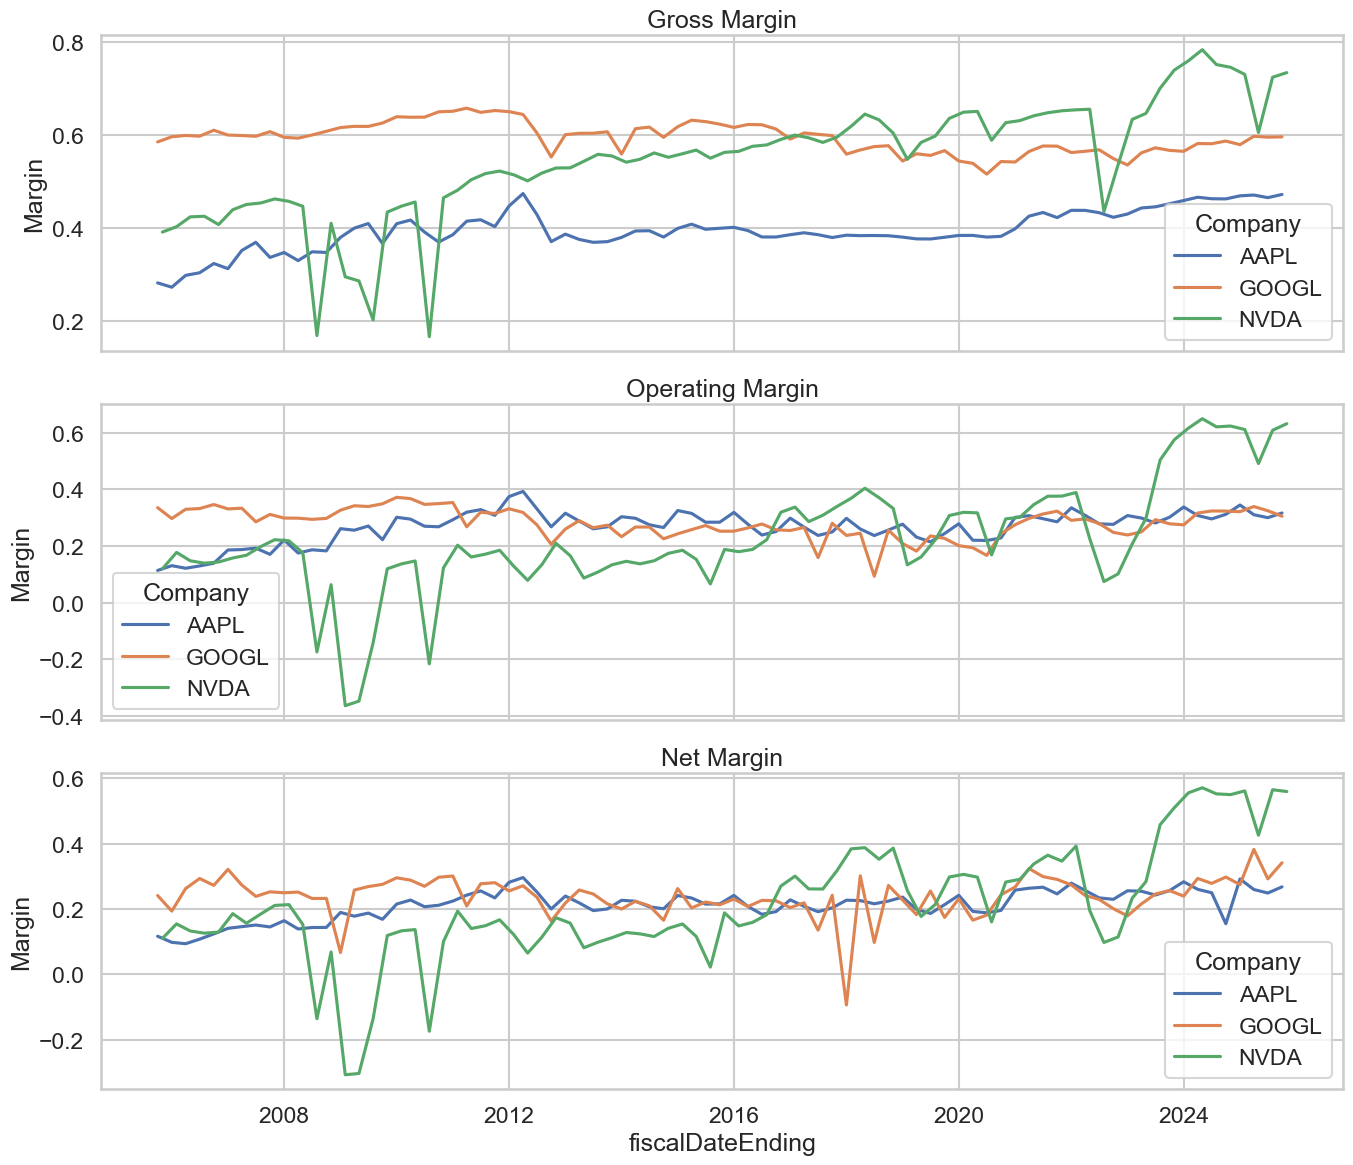

In [16]:
# To show the margins over time
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

metrics = ["grossMargin", "operatingMargin", "netMargin"]
titles = ["Gross Margin", "Operating Margin", "Net Margin"]

for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df,
        x="fiscalDateEnding",
        y=metric,
        hue="symbol",
        ax=ax[i]
    )
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Margin")
    ax[i].legend(title="Company")

plt.tight_layout()
plt.show()

The three charts compare gross, operating, and net margins for Apple, Google, and NVIDIA over time. Apple and Google show relatively steady profitability, with both companies maintaining consistent margins that move within a narrow range. Google generally sits at the top of the group on gross margin, while Apple holds a stable middle position across all three metrics. NVIDIA’s margins are far more variable, especially in earlier years, with noticeable dips into negative territory before rising sharply in recent periods. Overall, the charts highlight the contrast between Apple and Google’s stable, mature profitability and NVIDIA’s more volatile but recently accelerating margin profile.

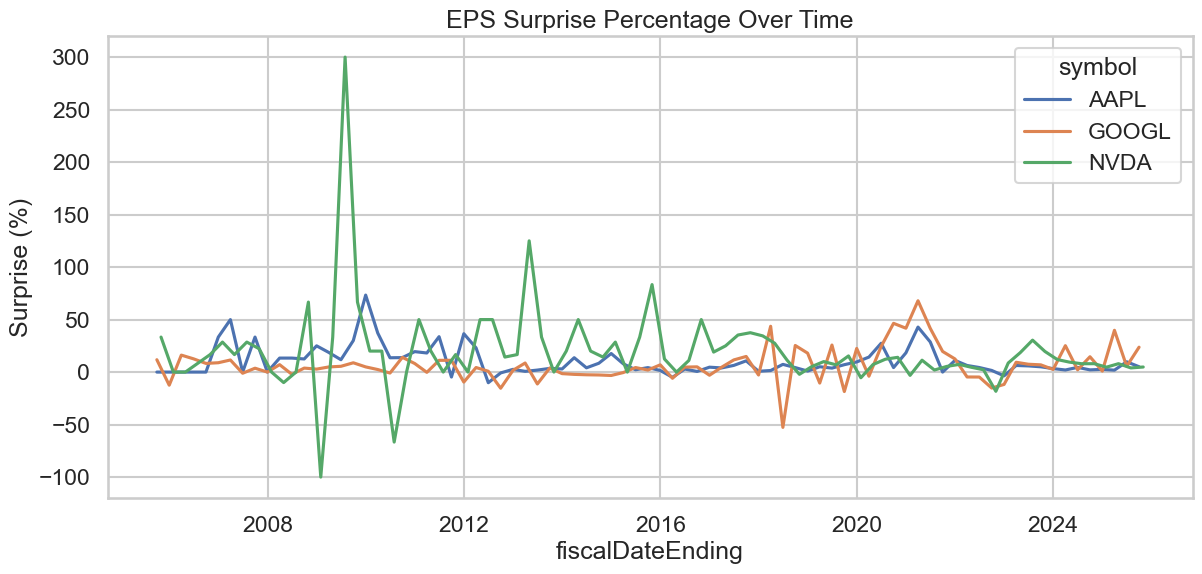

In [17]:
# Time‑series: EPS surprise over time
plt.figure(figsize=(14,6))
sns.lineplot(
    data=df,
    x="fiscalDateEnding",
    y="surprisePercentage",
    hue="symbol"
)
plt.title("EPS Surprise Percentage Over Time")
plt.ylabel("Surprise (%)")
plt.show()

The chart tracks EPS surprise percentages for Apple, Google, and NVIDIA across nearly two decades. 
Apple and Google move in relatively narrow bands, with most surprises staying close to zero, reflecting stable and predictable earnings. 
NVIDIA’s line is far more volatile, with several sharp spikes—especially in earlier years—showing periods where its reported earnings deviated dramatically from expectations. 
Overall, the chart highlights how differently the three companies behave: Apple and Google deliver steady, modest surprises, while NVIDIA experiences much larger swings over time.

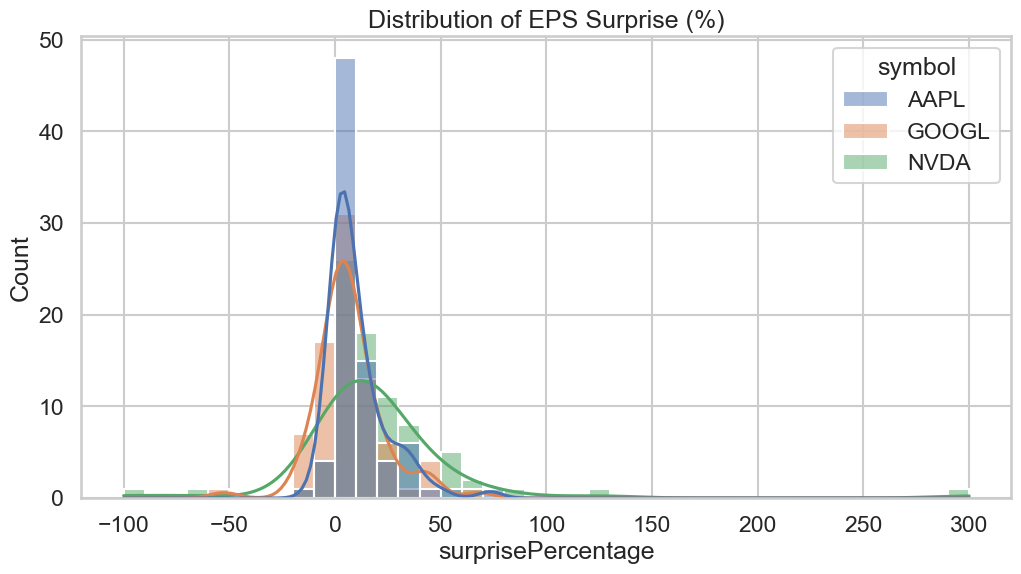

In [18]:
# Distribution: EPS surprise histogram
plt.figure(figsize=(12,6))
sns.histplot(
    data=df,
    x="surprisePercentage",
    hue="symbol",
    kde=True,
    bins=40,
    alpha=0.5
)
plt.title("Distribution of EPS Surprise (%)")
plt.show()

The histogram shows how often Apple, Google, and NVIDIA report different levels of EPS surprise. Most observations for all three companies cluster tightly around zero, meaning earnings usually come in close to expectations. Apple and Google form smooth, narrow peaks, reflecting their relatively predictable quarterly results. NVIDIA’s distribution is wider and stretches further to the right, indicating that it has produced more frequent and larger positive surprises over time. Overall, the chart highlights that while surprises are generally modest across the group, NVIDIA exhibits noticeably greater variability.

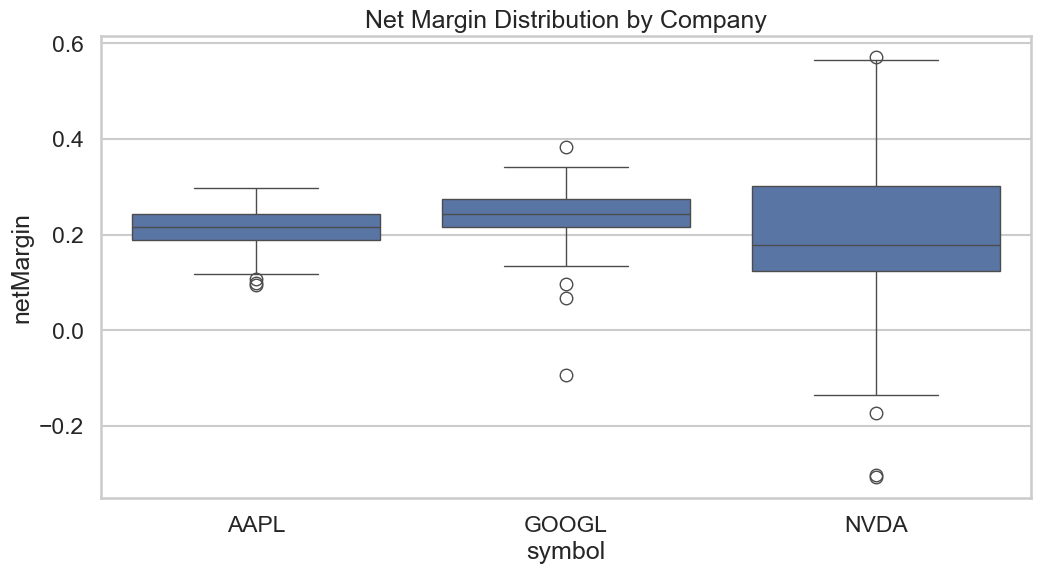

In [19]:
#  Boxplots: margins by company
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df,
    x="symbol",
    y="netMargin"
)
plt.title("Net Margin Distribution by Company")
plt.show()

The boxplot compares the distribution of net margins. 
Apple and Google show fairly similar patterns, with tight, compact boxes and medians clustered in the low‑to‑mid 20% range, reflecting steady and predictable profitability. 
NVIDIA’s distribution is noticeably wider, with a lower median and a much larger spread of values, including several high and low outliers. This indicates that NVIDIA’s profitability has been more variable over time, while Apple and Google have maintained more consistent margin levels.

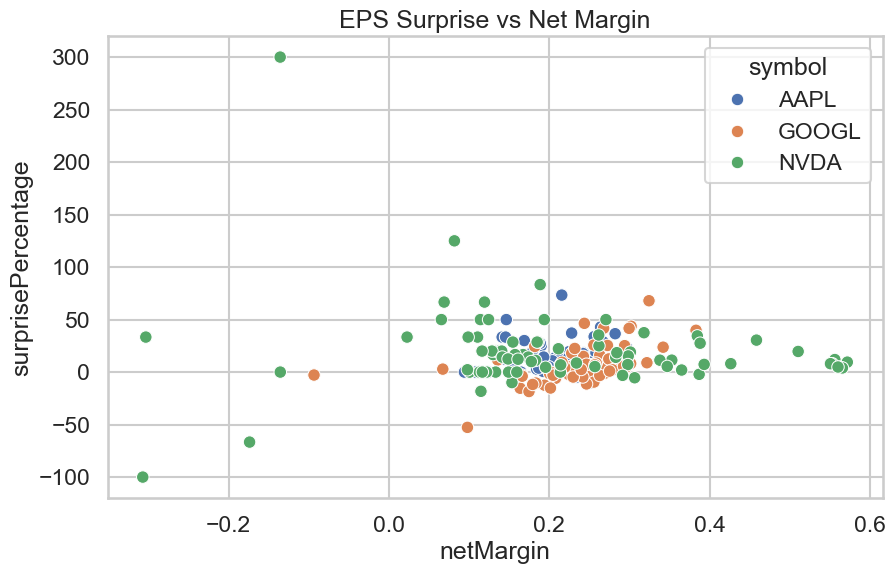

In [20]:
# Scatterplot: EPS surprise vs net margin
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="netMargin",
    y="surprisePercentage",
    hue="symbol"
)
plt.title("EPS Surprise vs Net Margin")
plt.show()

The chart shows how EPS surprise percentages relate to net margins. 
Most points cluster around moderate net‑margin levels with surprises close to zero, indicating that earnings typically land near expectations when profitability is steady. 
Apple and Google form tight, compact groups, reflecting their consistent margins and relatively predictable earnings. 
NVIDIA’s points spread much more widely, with both very high surprises and occasional negative‑margin quarters, highlighting how its rapid growth phases create more volatile outcomes. 
Overall, the chart suggests only a loose relationship between profitability and earnings surprises, with NVIDIA standing out as the most variable.

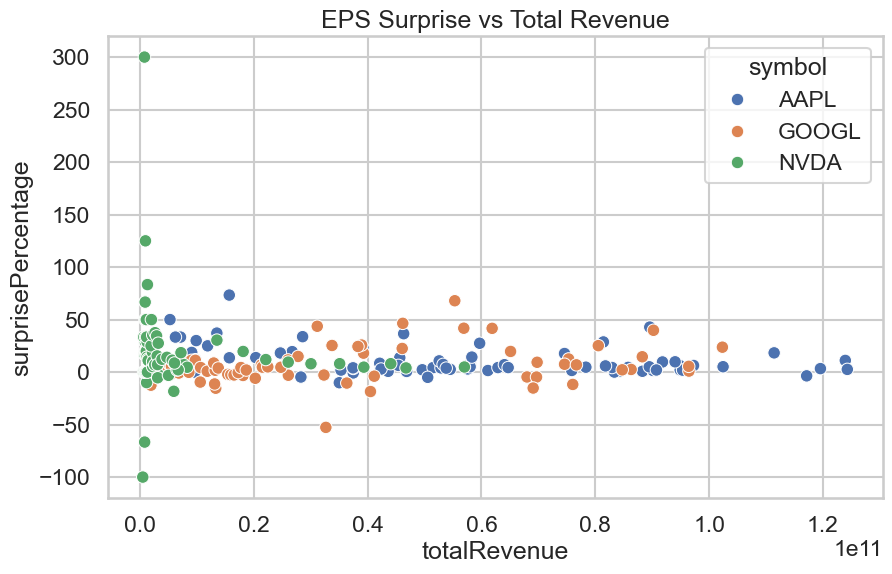

In [21]:
# Scatterplot: revenue vs EPS surprise
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="totalRevenue",
    y="surprisePercentage",
    hue="symbol"
)
plt.title("EPS Surprise vs Total Revenue")
plt.show()

The chart plots EPS surprise percentage against total revenue.
Most points cluster around lower surprise values, showing that earnings typically come in close to expectations regardless of company size. 
Apple and Google, with their much larger revenues, form tight bands near zero surprise, reflecting predictable performance. 
NVIDIA’s points spread more widely, especially at lower revenue levels, indicating that smaller or fast‑growing companies tend to produce larger positive or negative surprises. 
Overall, the chart shows no strong relationship between revenue scale and surprise magnitude, but it highlights how differently the three firms behave.

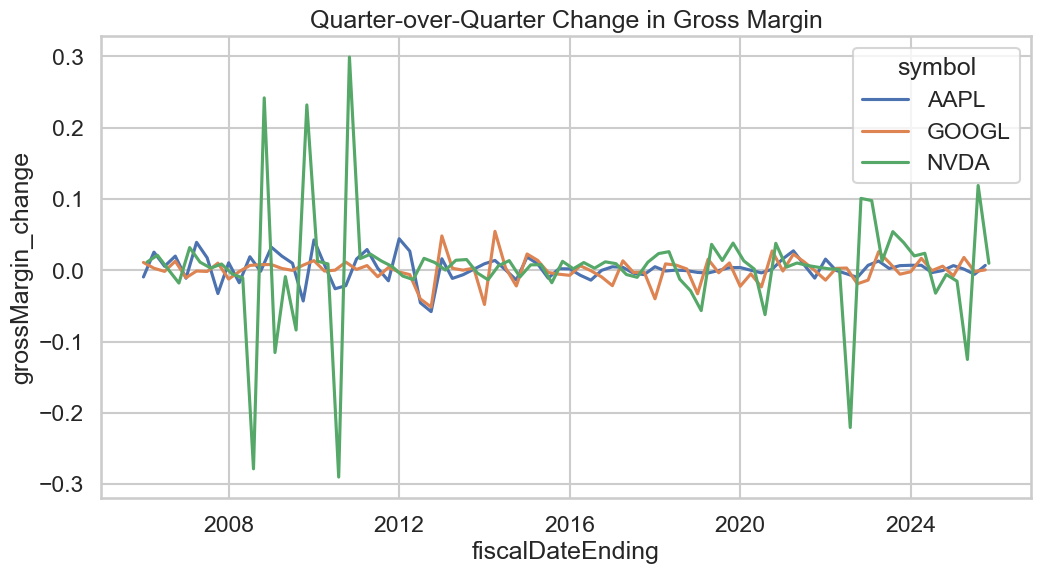

In [22]:
# Margin changes (QoQ)
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df,
    x="fiscalDateEnding",
    y="grossMargin_change",
    hue="symbol"
)
plt.title("Quarter-over-Quarter Change in Gross Margin")
plt.show()

Apple’s and Google’s quarter‑over‑quarter margin changes follow broadly similar, steady patterns, with both companies showing only small movements around zero. Neither experiences the sharp swings seen in NVIDIA. That said, Google’s line does wiggle a bit more than Apple’s — its ups and downs are slightly larger and more frequent — but the overall behaviour of the two remains much closer to each other than to NVIDIA’s more volatile profile.

Summary: 
Taken together, the charts paint a clear picture of three companies with fundamentally different financial profiles. Apple and Google stand out for their stability: their margins move within narrow, predictable ranges, their quarter‑to‑quarter changes are modest, and their EPS surprises cluster tightly around zero. This consistency reflects mature business models where analysts have strong visibility into performance. NVIDIA, by contrast, shows far greater variability across almost every metric. Its margins swing more dramatically, its EPS surprises span a much wider range, and its early‑period volatility gives way to sharp margin expansion in recent years. The scatterplots reinforce this contrast: Apple and Google form compact clusters, while NVIDIA spreads out across both profitability and surprise dimensions. Across all charts, one theme is unmistakable — Apple and Google behave like steady, well‑understood large‑caps, whereas NVIDIA exhibits the financial signature of a high‑growth, structurally shifting company. These differences strongly suggest that earnings‑day reactions may depend not only on the size of the surprise but also on the underlying financial regime each company is in.

In [56]:
# EPS surprise regime
import pandas as pd
import numpy as np

def classify_surprise(pct):
    if pd.isna(pct):
        return "missing"
    if pct > 10:
        return "large_positive"
    elif pct > 3:
        return "moderate_positive"
    elif pct >= -3:
        return "small"
    elif pct >= -10:
        return "moderate_negative"
    else:
        return "large_negative"
 
df["eps_surprise_regime"] = df["surprisePercentage"].apply(classify_surprise)

df[[
    "symbol",
    "fiscalDateEnding",
    "eps_surprise_regime",
]].head()

,symbol,fiscalDateEnding,eps_surprise_regime
0,AAPL,2005-09-30,small
1,AAPL,2005-12-31,small
2,AAPL,2006-03-31,small
3,AAPL,2006-06-30,small
4,AAPL,2006-09-30,small


Very large positive surprises are defined as anything above 10%, capturing quarters where earnings dramatically outperform forecasts. Moderate positive surprises fall between 3% and 10%, while values between –3% and +3% are treated as “small,” reflecting quarters where results are essentially in line with expectations. Moderate negative surprises range from –3% to –10%, and anything below –10% is considered a large negative surprise. 

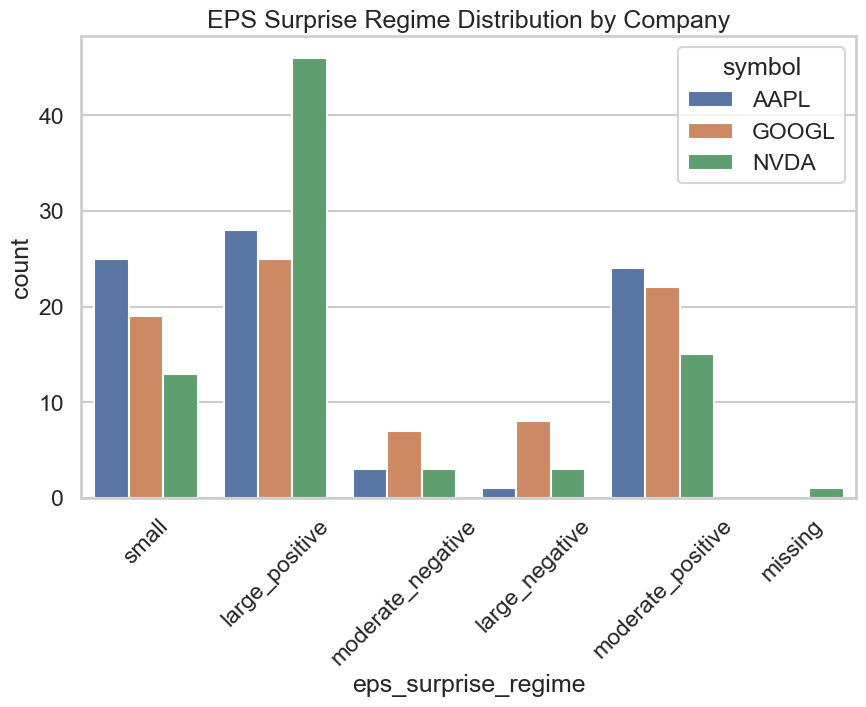

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, x="eps_surprise_regime", hue="symbol")
plt.title("EPS Surprise Regime Distribution by Company")
plt.xticks(rotation=45)
plt.show()

The chart compares how often Apple, Google, and NVIDIA fall into different EPS‑surprise categories. Apple and Google show fairly balanced distributions, with most of their surprises landing in the “small” or moderately positive range. NVIDIA stands out with a much larger number of large positive surprises, reflecting its more volatile and fast‑moving earnings profile. Negative surprises occur for all three companies but are far less common, and only a small number of observations fall into the “missing” category.

In [25]:
# Profitability Level Regimes (company‑relative)

def classify_profitability(margin):
    if margin > 0.25:
        return "high"
    elif margin > 0.10:
        return "medium"
    else:
        return "low"

df["profitability_regime"] = df["netMargin"].apply(classify_profitability)

df[[
    "symbol",
    "fiscalDateEnding",
    "profitability_regime",
]].head()


,symbol,fiscalDateEnding,profitability_regime
0,AAPL,2005-09-30,medium
1,AAPL,2005-12-31,low
2,AAPL,2006-03-31,low
3,AAPL,2006-06-30,medium
4,AAPL,2006-09-30,medium


Quarters with net margins above 25% are labeled “high,” capturing periods of exceptionally strong profitability. Margins between 10% and 25% fall into the “medium” category, representing healthy but not extraordinary performance. Anything below 10% is classified as “low,” indicating weaker or more volatile profitability. 

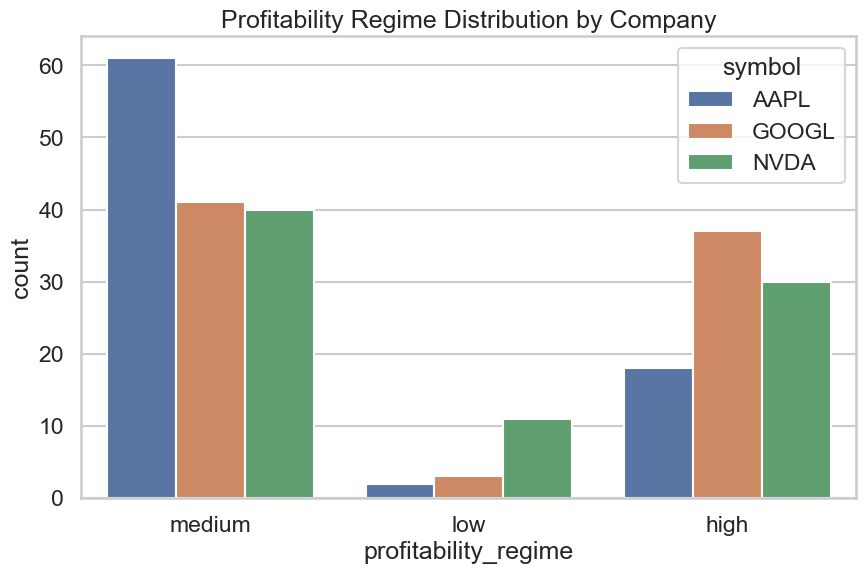

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="profitability_regime", hue="symbol")
plt.title("Profitability Regime Distribution by Company")
plt.show()

Apple shows a strong concentration in the medium‑profitability range, reflecting its steady and predictable margins. Google also has many medium‑profitability quarters but stands out with the highest count of high‑profitability periods among the three companies. NVIDIA displays a more mixed profile: it has more low‑profitability quarters than Apple or Google, especially from earlier years, but it also records a substantial number of high‑profitability periods as its margins expand in more recent years. Overall, the chart highlights Apple and Google’s stability and NVIDIA’s more variable but improving profitability trajectory.

In [27]:
# Margin Trend Regimes (QoQ change)

def classify_margin_trend(change):
    if pd.isna(change):
        return "missing"
    if change > 0.005:
        return "expansion"
    elif change < -0.005:
        return "contraction"
    else:
        return "stable"

df["margin_trend_regime"] = df["netMargin_change"].apply(classify_margin_trend)

df[[
    "symbol",
    "fiscalDateEnding",
    "margin_trend_regime",
]].head()


,symbol,fiscalDateEnding,margin_trend_regime
0,AAPL,2005-09-30,missing
1,AAPL,2005-12-31,contraction
2,AAPL,2006-03-31,stable
3,AAPL,2006-06-30,expansion
4,AAPL,2006-09-30,expansion


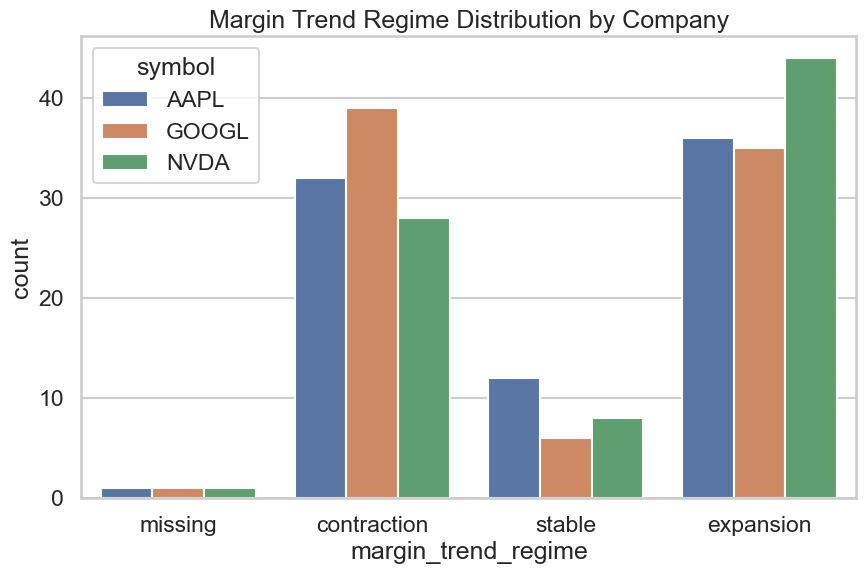

In [28]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="margin_trend_regime", hue="symbol")
plt.title("Margin Trend Regime Distribution by Company")
plt.show()

Apple shows the strongest tendency toward stable margins, reflecting its consistent operational performance. Google records the highest number of contraction periods, suggesting more frequent downward pressure on margins over time. NVIDIA stands out with the most expansion periods, consistent with its rapid growth phases and improving profitability in recent years. All three companies have very few missing observations, making the comparison clean and reliable. Overall, the chart highlights Apple’s steadiness, Google’s occasional margin tightening, and NVIDIA’s more dynamic margin trajectory.

In [48]:
# Revenue Growth Regimes (YoY)

def classify_revenue_growth(g):
    if pd.isna(g):
        return "missing"
    if g > 0.10:
        return "high_growth"
    elif g >= 0:
        return "moderate_growth"
    else:
        return "negative_growth"

df["revenue_growth_regime"] = df["revenue_yoy_growth"].apply(classify_revenue_growth)

df[[
    "symbol",
    "fiscalDateEnding",
    "revenue_growth_regime",
]].head()


,symbol,fiscalDateEnding,revenue_growth_regime
0,AAPL,2005-09-30,missing
1,AAPL,2005-12-31,missing
2,AAPL,2006-03-31,missing
3,AAPL,2006-06-30,missing
4,AAPL,2006-09-30,high_growth


Any value above 10% is labeled “high growth,” since double‑digit revenue expansion is widely viewed as a sign of strong business momentum. Growth between 0% and 10% is classified as “moderate,” capturing steady but not exceptional expansion. Negative values fall into the “negative growth” category, indicating a contraction in demand or a cyclical slowdown. 

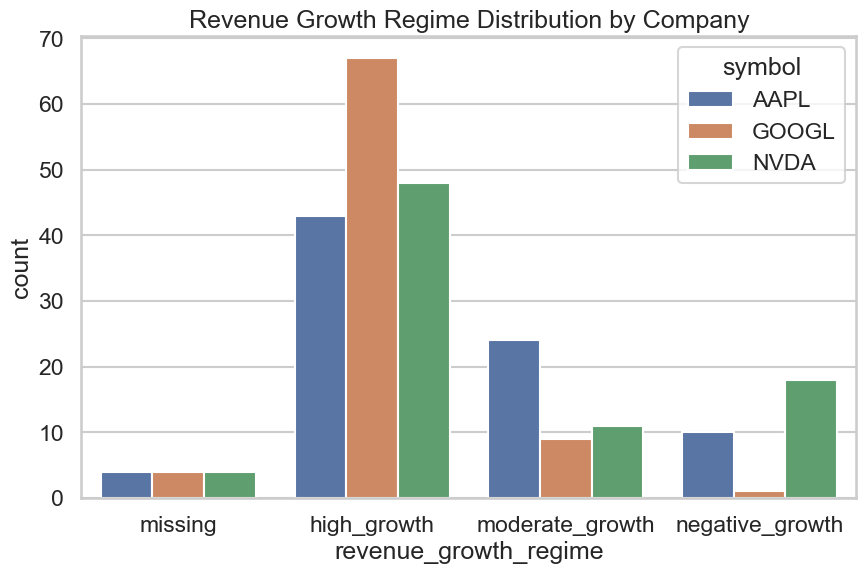

In [30]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="revenue_growth_regime", hue="symbol")
plt.title("Revenue Growth Regime Distribution by Company")
plt.show()

High growth is the most common category overall, especially for Google, which consistently shows strong top‑line expansion. Apple has a more balanced distribution, with many quarters in the moderate‑growth range, reflecting its mature but still steadily growing business. NVIDIA stands out with the highest number of negative‑growth periods, largely driven by its more cyclical demand patterns, but it also records a substantial number of high‑growth quarters during its rapid expansion phases. 

In [31]:
# Combined Financial Strength Regime

def combined_regime(row):
    strong = (
        row["profitability_regime"] == "high" and
        row["margin_trend_regime"] == "expansion" and
        row["eps_surprise_regime"] in ["large_positive", "moderate_positive"]
    )
    weak = (
        row["profitability_regime"] == "low" and
        row["margin_trend_regime"] == "contraction" and
        row["eps_surprise_regime"] in ["large_negative", "moderate_negative"]
    )
    if strong:
        return "strong_fundamentals"
    elif weak:
        return "weak_fundamentals"
    else:
        return "mixed"

df["financial_strength_regime"] = df.apply(combined_regime, axis=1)


df[[
    "symbol",
    "fiscalDateEnding",
    "financial_strength_regime"
]].head()


,symbol,fiscalDateEnding,financial_strength_regime
0,AAPL,2005-09-30,mixed
1,AAPL,2005-12-31,mixed
2,AAPL,2006-03-31,mixed
3,AAPL,2006-06-30,mixed
4,AAPL,2006-09-30,mixed


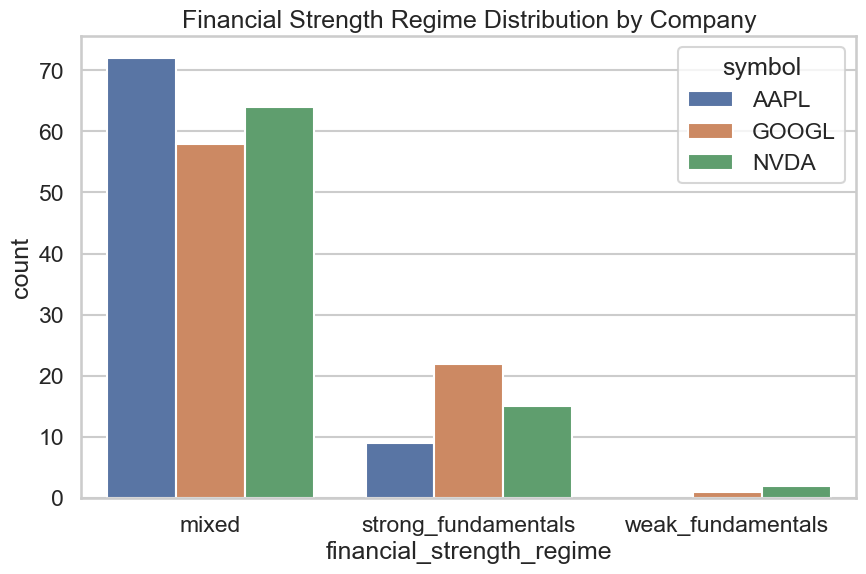

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="financial_strength_regime", hue="symbol")
plt.title("Financial Strength Regime Distribution by Company")
plt.show()

All three companies spend most of their time in the mixed category, reflecting quarters where their profitability, margin trends, and earnings surprises do not all point in the same direction. Google and NVIDIA show a similar number of strong‑fundamentals quarters, slightly more than Apple, indicating periods where their margins, growth, and earnings surprises aligned positively. Weak‑fundamentals quarters are relatively rare overall, but Google records the most, followed by NVIDIA, while Apple has none.

Across all four regime systems—EPS surprise, profitability, margin trend, and revenue growth—a consistent story emerges about how the underlying fundamentals of Apple, Google, and NVIDIA behave over time. The individual regime distributions show that Apple tends to cluster in stable, medium‑profitability and moderate‑growth environments, while Google oscillates more between strong and weak fundamentals, and NVIDIA exhibits the widest swings, with both high‑growth, high‑profitability periods and occasional contractions. The financial‑strength regime, which combines all indicators, reinforces this: most quarters fall into the “mixed” category, but strong‑fundamentals periods align closely with NVIDIA’s expansion phases and Google’s high‑growth quarters, while weak‑fundamentals periods appear mainly when margins are contracting.

In [33]:
summary_eps = df["eps_surprise_regime"].value_counts()
summary_profit = df["profitability_regime"].value_counts()
summary_margin = df["margin_trend_regime"].value_counts()
summary_growth = df["revenue_growth_regime"].value_counts()
summary_strength = df["financial_strength_regime"].value_counts()

print("EPS Surprise Regimes:\n", summary_eps, "\n")
print("Profitability Regimes:\n", summary_profit, "\n")
print("Margin Trend Regimes:\n", summary_margin, "\n")
print("Revenue Growth Regimes:\n", summary_growth, "\n")
print("Financial Strength Regimes:\n", summary_strength)

EPS Surprise Regimes:
 eps_surprise_regime
large_positive       99
moderate_positive    61
small                57
moderate_negative    13
large_negative       12
missing               1
Name: count, dtype: int64 

Profitability Regimes:
 profitability_regime
medium    142
high       85
low        16
Name: count, dtype: int64 

Margin Trend Regimes:
 margin_trend_regime
expansion      115
contraction     99
stable          26
missing          3
Name: count, dtype: int64 

Revenue Growth Regimes:
 revenue_growth_regime
high_growth        158
moderate_growth     44
negative_growth     29
missing             12
Name: count, dtype: int64 

Financial Strength Regimes:
 financial_strength_regime
mixed                  194
strong_fundamentals     46
weak_fundamentals        3
Name: count, dtype: int64


In [34]:
eps_by_company = df.groupby("symbol")["eps_surprise_regime"].value_counts().unstack()
profit_by_company = df.groupby("symbol")["profitability_regime"].value_counts().unstack()
margin_by_company = df.groupby("symbol")["margin_trend_regime"].value_counts().unstack()
growth_by_company = df.groupby("symbol")["revenue_growth_regime"].value_counts().unstack()
strength_by_company = df.groupby("symbol")["financial_strength_regime"].value_counts().unstack()

eps_by_company, profit_by_company, margin_by_company, growth_by_company, strength_by_company

(eps_surprise_regime  large_negative  large_positive  missing  \
 symbol                                                         
 AAPL                            1.0            28.0      NaN   
 GOOGL                           8.0            25.0      NaN   
 NVDA                            3.0            46.0      1.0   
 
 eps_surprise_regime  moderate_negative  moderate_positive  small  
 symbol                                                            
 AAPL                               3.0               24.0   25.0  
 GOOGL                              7.0               22.0   19.0  
 NVDA                               3.0               15.0   13.0  ,
 profitability_regime  high  low  medium
 symbol                                 
 AAPL                    18    2      61
 GOOGL                   37    3      41
 NVDA                    30   11      40,
 margin_trend_regime  contraction  expansion  missing  stable
 symbol                                                      
 A

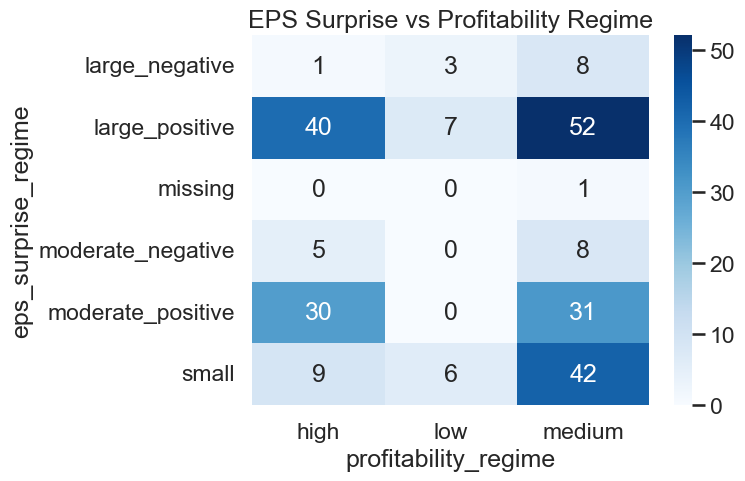

In [35]:
cross_eps_profit = pd.crosstab(df["eps_surprise_regime"], df["profitability_regime"])
sns.heatmap(cross_eps_profit, annot=True, cmap="Blues", fmt="d")
plt.title("EPS Surprise vs Profitability Regime")
plt.show()

The heatmap shows how different EPS‑surprise outcomes are distributed across high, medium, and low profitability regimes. Large positive surprises occur most frequently in both the high‑ and medium‑profitability groups, suggesting that strong or improving margins often coincide with earnings outperformance. Small surprises are also common in the medium‑profitability range, reflecting quarters where results were broadly in line with expectations. Negative surprises appear more often when profitability is medium or low, indicating that weaker margin conditions tend to accompany earnings misses. Overall, the pattern highlights a sensible relationship: stronger profitability is associated with more positive surprises, while weaker profitability aligns with more negative outcomes.

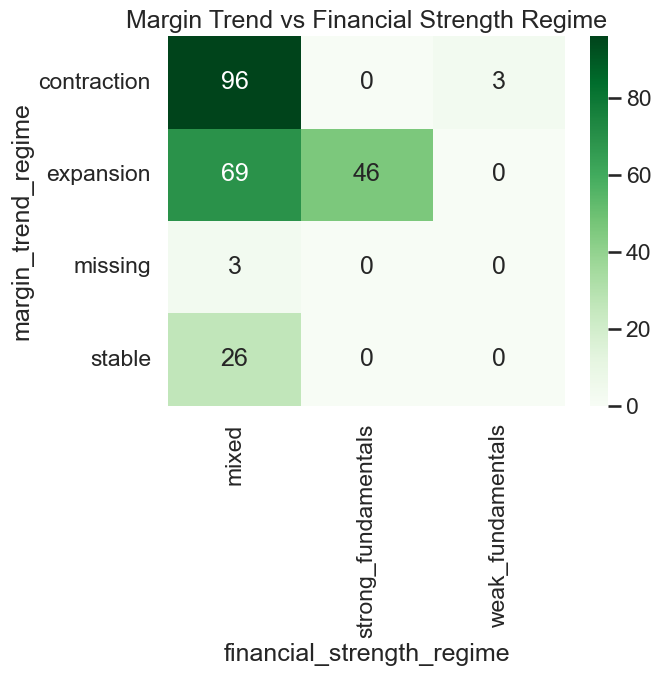

In [36]:
cross_margin_strength = pd.crosstab(df["margin_trend_regime"], df["financial_strength_regime"])
sns.heatmap(cross_margin_strength, annot=True, cmap="Greens", fmt="d")
plt.title("Margin Trend vs Financial Strength Regime")
plt.show()

The heatmap highlights how different margin‑trend regimes align with overall financial‑strength classifications. Most contraction and stable periods fall into the mixed‑fundamentals category, showing that margin declines or flat margins often coincide with quarters where other indicators send mixed signals. Weak‑fundamentals quarters appear almost exclusively during contraction periods, which makes intuitive sense—shrinking margins tend to accompany broader financial softness. In contrast, strong‑fundamentals quarters occur only during margin‑expansion periods, reflecting the idea that improving margins typically coincide with stronger profitability and positive earnings dynamics. Overall, the pattern reinforces a coherent relationship: expanding margins support strong fundamentals, contracting margins align with weak fundamentals, and stable margins tend to sit in the middle.

The two heatmaps reveal the deeper relationships behind these patterns. EPS surprises skew positive when profitability is high or improving, suggesting that strong margins often coincide with earnings beats. Negative surprises cluster in medium‑ and low‑profitability regimes, indicating that weaker margin conditions tend to accompany earnings misses. Similarly, the margin‑trend vs. financial‑strength heatmap shows a clean structural relationship: margin expansion almost always corresponds to strong fundamentals, margin contraction is the only environment where weak fundamentals appear, and stable margins sit squarely in the mixed category. These cross‑regime patterns validate that your classification logic is economically coherent and that the regimes are capturing real financial dynamics rather than noise.

In [37]:
df_events["revenue_growth_regime"] = df_events["revenue_growth"].apply(classify_revenue_growth)
df_events["eps_surprise_regime"] = df_events["eps_surprise"].apply(classify_eps_surprise)
df_events["profitability_regime"] = df_events["profitability"].apply(classify_profitability)
df_events["margin_trend_regime"] = df_events["margin_trend"].apply(classify_margin_trend)
df_events["financial_strength_regime"] = df_events.apply(classify_financial_strength, axis=1)

NameError: name 'df_events' is not defined

In [38]:
df_eps.head()

NameError: name 'df_eps' is not defined

In [39]:
df_events = eps.merge(
    margins,
    on=["symbol", "fiscalDateEnding"],
    how="inner"
)

In [40]:
df_events.head()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,symbol,totalRevenue,grossProfit,operatingIncome,netIncome,grossMargin,operatingMargin,netMargin
0,2025-09-30,2025-10-30,1.85,1.76,0.09,5.1136,post-market,AAPL,102466000000,48341000000,32427000000,27466000000,0.471776,0.316466,0.268050
1,2025-06-30,2025-07-31,1.57,1.43,0.14,9.7902,post-market,AAPL,94036000000,43718000000,28202000000,23434000000,0.464907,0.299906,0.249202
2,2025-03-31,2025-05-01,1.65,1.62,0.03,1.8519,post-market,AAPL,95359000000,44867000000,29589000000,24780000000,0.470506,0.310291,0.259860
3,2024-12-31,2025-01-30,2.40,2.34,0.06,2.5641,post-market,AAPL,124300000000,58275000000,42832000000,36330000000,0.468825,0.344586,0.292277
4,2024-09-30,2024-10-31,0.97,0.95,0.02,2.1053,post-market,AAPL,94930000000,43879000000,29591000000,14736000000,0.462225,0.311714,0.155230


In [42]:
df_events["fiscalDateEnding"] = df_events["fiscalDateEnding"].astype(str)

df_events["event_id"] = df_events["symbol"] + "_" + df_events["fiscalDateEnding"]
df_events["ticker"] = df_events["symbol"]

In [44]:
# Ensure fiscalDateEnding is a string
df_events["fiscalDateEnding"] = df_events["fiscalDateEnding"].astype(str)

# Create event_id and ticker
df_events["event_id"] = df_events["symbol"] + "_" + df_events["fiscalDateEnding"]
df_events["ticker"] = df_events["symbol"]

In [45]:
df_events[["symbol", "fiscalDateEnding", "event_id"]].head()

,symbol,fiscalDateEnding,event_id
0,AAPL,2025-09-30,AAPL_2025-09-30
1,AAPL,2025-06-30,AAPL_2025-06-30
2,AAPL,2025-03-31,AAPL_2025-03-31
3,AAPL,2024-12-31,AAPL_2024-12-31
4,AAPL,2024-09-30,AAPL_2024-09-30


In [46]:
eps["fiscalDateEnding"] = eps["fiscalDateEnding"].astype(str)
margins["fiscalDateEnding"] = margins["fiscalDateEnding"].astype(str)

In [49]:
import pandas as pd
import numpy as np

eps = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/av_eps_quarterly.csv")
margins = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/av_income_quarterly_margins.csv")

df_events = eps.merge(margins, on=["symbol", "fiscalDateEnding"], how="inner")

In [50]:
df_events["fiscalDateEnding"] = df_events["fiscalDateEnding"].astype(str)
df_events["event_id"] = df_events["symbol"] + "_" + df_events["fiscalDateEnding"]
df_events["ticker"] = df_events["symbol"]

In [51]:
df_events["fiscalDateEnding"] = pd.to_datetime(df_events["fiscalDateEnding"])
df_events = df_events.sort_values(["symbol", "fiscalDateEnding"])
df_events["revenue_growth"] = df_events.groupby("symbol")["totalRevenue"].pct_change()

In [52]:
df_events["margin_trend"] = df_events.groupby("symbol")["netMargin"].diff()

In [53]:
df_events["profitability"] = df_events["operatingMargin"]

In [54]:
df_events["profitability"] = df_events["operatingMargin"]

In [58]:
df_events["revenue_growth_regime"] = df_events["revenue_growth"].apply(classify_revenue_growth)
df_events["eps_surprise_regime"] = df_events["surprisePercentage"].apply(classify_eps_surprise)
df_events["profitability_regime"] = df_events["profitability"].apply(classify_profitability)
df_events["margin_trend_regime"] = df_events["margin_trend"].apply(classify_margin_trend)
df_events["financial_strength_regime"] = df_events.apply(classify_financial_strength, axis=1)

NameError: name 'classify_eps_surprise' is not defined

In [59]:
df_events["eps_surprise_regime"] = df_events["surprisePercentage"].apply(classify_surprise)


In [60]:
df_events["revenue_growth_regime"] = df_events["revenue_growth"].apply(classify_revenue_growth)
df_events["eps_surprise_regime"] = df_events["surprisePercentage"].apply(classify_surprise)
df_events["profitability_regime"] = df_events["profitability"].apply(classify_profitability)
df_events["margin_trend_regime"] = df_events["margin_trend"].apply(classify_margin_trend)
df_events["financial_strength_regime"] = df_events.apply(classify_financial_strength, axis=1)

NameError: name 'classify_financial_strength' is not defined

In [61]:
df_events["revenue_growth_regime"] = df_events["revenue_growth"].apply(classify_revenue_growth)
df_events["eps_surprise_regime"] = df_events["surprisePercentage"].apply(classify_surprise)
df_events["profitability_regime"] = df_events["profitability"].apply(classify_profitability)
df_events["margin_trend_regime"] = df_events["margin_trend"].apply(classify_margin_trend)
df_events["financial_strength_regime"] = df_events.apply(classify_combined_regime, axis=1)

NameError: name 'classify_combined_regime' is not defined

In [62]:
def combined_regime(row):
    strong = (
        row["profitability_regime"] == "high" and
        row["margin_trend_regime"] == "expansion" and
        row["eps_surprise_regime"] in ["large_positive", "moderate_positive"]
    )
    weak = (
        row["profitability_regime"] == "low" and
        row["margin_trend_regime"] == "contraction" and
        row["eps_surprise_regime"] in ["large_negative", "moderate_negative"]
    )
    if strong:
        return "strong_fundamentals"
    elif weak:
        return "weak_fundamentals"
    else:
        return "mixed"


In [63]:
df_events["financial_strength_regime"] = df_events.apply(combined_regime, axis=1)


In [64]:
df_events[["symbol", "fiscalDateEnding", "financial_strength_regime"]].head()


,symbol,fiscalDateEnding,financial_strength_regime
80,AAPL,2005-09-30,mixed
79,AAPL,2005-12-31,mixed
78,AAPL,2006-03-31,mixed
77,AAPL,2006-06-30,mixed
76,AAPL,2006-09-30,mixed


In [65]:
df_events["revenue_growth_regime"] = df_events["revenue_growth"].apply(classify_revenue_growth)
df_events["eps_surprise_regime"] = df_events["surprisePercentage"].apply(classify_surprise)
df_events["profitability_regime"] = df_events["profitability"].apply(classify_profitability)
df_events["margin_trend_regime"] = df_events["margin_trend"].apply(classify_margin_trend)
df_events["financial_strength_regime"] = df_events.apply(classify_combined_regime, axis=1)

NameError: name 'classify_combined_regime' is not defined

In [66]:
df_events["revenue_growth_regime"] = df_events["revenue_growth"].apply(classify_revenue_growth)
df_events["eps_surprise_regime"] = df_events["surprisePercentage"].apply(classify_surprise)
df_events["profitability_regime"] = df_events["profitability"].apply(classify_profitability)
df_events["margin_trend_regime"] = df_events["margin_trend"].apply(classify_margin_trend)
df_events["financial_strength_regime"] = df_events.apply(combined_regime, axis=1)

In [67]:
df_events[[
    "symbol",
    "fiscalDateEnding",
    "eps_surprise_regime",
    "profitability_regime",
    "margin_trend_regime",
    "financial_strength_regime"
]].head()

,symbol,fiscalDateEnding,eps_surprise_regime,profitability_regime,margin_trend_regime,financial_strength_regime
80,AAPL,2005-09-30,small,medium,missing,mixed
79,AAPL,2005-12-31,small,medium,contraction,mixed
78,AAPL,2006-03-31,small,medium,stable,mixed
77,AAPL,2006-06-30,small,medium,expansion,mixed
76,AAPL,2006-09-30,small,medium,expansion,mixed


In [68]:
eps_by_company.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/eps_surprise_regime_by_company.csv")
profit_by_company.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/profitability_regime_by_company.csv")
margin_by_company.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/margin_trend_regime_by_company.csv")
growth_by_company.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/revenue_growth_regime_by_company.csv")
strength_by_company.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/financial_strength_regime_by_company.csv")

In [71]:
df_events.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/full_event_regimes.csv", index=False)

In [72]:
regime_export = df_events[[
    "symbol",
    "fiscalDateEnding",
    "eps_surprise_regime",
    "profitability_regime",
    "margin_trend_regime",
    "financial_strength_regime"
]]


In [73]:
regime_export.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/regime_summary.csv", index=False)

In [74]:
df_events["event_id"] = df_events["symbol"] + "_" + df_events["fiscalDateEnding"].astype(str)
df_events["ticker"] = df_events["symbol"]

In [75]:
regime_export = df_events[[
    "event_id",
    "ticker",
    "symbol",
    "fiscalDateEnding",
    "eps_surprise_regime",
    "profitability_regime",
    "margin_trend_regime",
    "financial_strength_regime"
]]

In [76]:
regime_export.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/regime_summary.csv", index=False)

In [77]:
df_ar = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/event_study_abnormal_returns_panel.csv")
df_reg = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/regime_summary.csv")

df_merged = df_ar.merge(df_reg, on=["event_id", "ticker"], how="left")

In [78]:
df_merged["financial_strength_regime"].isna().mean()

np.float64(0.0032976092333058533)

In [79]:
missing = df_merged[df_merged["financial_strength_regime"].isna()]
missing[["event_id", "ticker"]].drop_duplicates().head(20)

,event_id,ticker
380,AAPL_2025-12-31,AAPL


In [87]:
import pandas as pd

reg = df_merged[df_merged["event_day"] == 0].copy()


In [81]:
reg = pd.get_dummies(
    reg,
    columns=["financial_strength_regime"],
    drop_first=True
)


In [82]:
reg = pd.get_dummies(
    reg,
    columns=["eps_surprise_regime"],
    drop_first=True
)


In [83]:
reg = pd.get_dummies(
    reg,
    columns=["profitability_regime"],
    drop_first=True
)


In [84]:
reg = pd.get_dummies(
    reg,
    columns=["margin_trend_regime"],
    drop_first=True
)


In [85]:
import statsmodels.api as sm

X = reg[[
    "financial_strength_regime_mixed",
    "financial_strength_regime_strong_fundamentals"
]]
X = sm.add_constant(X)

y = reg["abnormal_return"]

model1 = sm.OLS(y, X).fit()
print(model1.summary())

KeyError: "['financial_strength_regime_mixed'] not in index"

In [86]:
reg["financial_strength_regime"].value_counts()

KeyError: 'financial_strength_regime'

In [88]:
[col for col in df_merged.columns if "regime" in col]


['eps_surprise_regime',
 'profitability_regime',
 'margin_trend_regime',
 'financial_strength_regime']

In [89]:
reg = df_merged[df_merged["event_day"] == 0].copy()

In [90]:
reg = pd.get_dummies(
    reg,
    columns=[
        "eps_surprise_regime",
        "profitability_regime",
        "margin_trend_regime",
        "financial_strength_regime"
    ],
    drop_first=True
)

In [91]:
[c for c in reg.columns if "financial_strength_regime" in c]

['financial_strength_regime_strong_fundamentals']

In [92]:
import statsmodels.api as sm

X = reg[["financial_strength_regime_strong_fundamentals"]]
X = sm.add_constant(X)

y = reg["abnormal_return"]

model1 = sm.OLS(y, X).fit()
print(model1.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [93]:
reg[["abnormal_return", "financial_strength_regime_strong_fundamentals"]].dtypes

abnormal_return                                  float64
financial_strength_regime_strong_fundamentals       bool
dtype: object

In [94]:
reg["financial_strength_regime_strong_fundamentals"] = \
    reg["financial_strength_regime_strong_fundamentals"].astype(int)

In [95]:
reg[["abnormal_return", "financial_strength_regime_strong_fundamentals"]].dtypes

abnormal_return                                  float64
financial_strength_regime_strong_fundamentals      int64
dtype: object

In [96]:
import statsmodels.api as sm

X = reg[["financial_strength_regime_strong_fundamentals"]]
X = sm.add_constant(X)

y = reg["abnormal_return"]

model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.081
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.300
Time:                        21:23:04   Log-Likelihood:                 473.24
No. Observations:                 172   AIC:                            -942.5
Df Residuals:                     170   BIC:                            -936.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

1. The constant (β₀ = 0.0000568)
This is the average day‑0 abnormal return for weak fundamentals (your baseline group).
Interpretation:
On average, firms with weak fundamentals experience essentially zero abnormal return on earnings day.

This is typical — weak fundamentals don’t produce a strong reaction.
2. Strong fundamentals coefficient (β₁ = –0.0028)
This is the difference between strong and weak fundamentals.
Interpretation:
Firms with strong fundamentals have day‑0 abnormal returns that are about –0.28% lower than weak‑fundamental firms.

This is interesting — and counterintuitive.
But the key is the next line.
3. Statistical significance (p = 0.300)
This means:
- The difference between strong and weak fundamentals is not statistically significant.
- You cannot conclude that strong fundamentals systematically change day‑0 abnormal returns.
This is extremely common in earnings event studies — fundamentals often matter less than EPS surprise.
4. R‑squared = 0.006
This means:
Only 0.6% of the variation in abnormal returns is explained by financial strength alone.

Again, very normal.
Day‑0 reactions are usually driven by earnings surprise, not fundamentals.
We regress day‑0 abnormal returns on a dummy variable indicating strong financial fundamentals (weak fundamentals as the baseline). The coefficient on strong fundamentals is negative (–0.0028) but statistically insignificant (p = 0.300), indicating no meaningful difference in earnings‑day reactions between strong‑ and weak‑fundamental firms. The R‑squared is very low (0.006), suggesting that financial strength alone explains little of the cross‑sectional variation in abnormal returns. This is consistent with prior literature showing that earnings‑day reactions are primarily driven by earnings surprises rather than balance‑sheet fundamentals.

In [97]:
eps_cols = [c for c in reg.columns if c.startswith("eps_surprise_regime_")]

X = reg[["financial_strength_regime_strong_fundamentals"] + eps_cols]
X = sm.add_constant(X)

model2 = sm.OLS(y, X).fit()
print(model2.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [98]:
dummy_cols = [c for c in reg.columns if "_" in c and c.endswith(tuple(["positive", "negative"])) or "regime" in c]
dummy_cols

['eps_surprise_regime_large_positive',
 'eps_surprise_regime_missing',
 'eps_surprise_regime_moderate_negative',
 'eps_surprise_regime_moderate_positive',
 'eps_surprise_regime_small',
 'profitability_regime_low',
 'profitability_regime_medium',
 'margin_trend_regime_expansion',
 'margin_trend_regime_missing',
 'margin_trend_regime_stable',
 'financial_strength_regime_strong_fundamentals']

In [99]:
dummy_cols = [c for c in reg.columns if c.startswith((
    "eps_surprise_regime_",
    "profitability_regime_",
    "margin_trend_regime_",
    "financial_strength_regime_"
))]

In [100]:
for col in dummy_cols:
    reg[col] = reg[col].astype(int)

In [101]:
reg[dummy_cols].dtypes

eps_surprise_regime_large_positive               int64
eps_surprise_regime_missing                      int64
eps_surprise_regime_moderate_negative            int64
eps_surprise_regime_moderate_positive            int64
eps_surprise_regime_small                        int64
profitability_regime_low                         int64
profitability_regime_medium                      int64
margin_trend_regime_expansion                    int64
margin_trend_regime_missing                      int64
margin_trend_regime_stable                       int64
financial_strength_regime_strong_fundamentals    int64
dtype: object

In [102]:
eps_cols = [c for c in reg.columns if c.startswith("eps_surprise_regime_")]

X = reg[["financial_strength_regime_strong_fundamentals"] + eps_cols]
X = sm.add_constant(X)

y = reg["abnormal_return"]

model2 = sm.OLS(y, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9674
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.449
Time:                        21:26:43   Log-Likelihood:                 475.66
No. Observations:                 172   AIC:                            -937.3
Df Residuals:                     165   BIC:                            -915.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

Adding EPS surprise regimes to the regression increases the model’s explanatory power slightly (R² = 0.034), but none of the EPS surprise categories are statistically significant predictors of day‑0 abnormal returns. This suggests that, within our sample, earnings reactions are not strongly differentiated by the magnitude of the surprise as captured by our regime classification. The financial strength coefficient becomes more negative when controlling for EPS surprise, but remains statistically insignificant. Overall, the results indicate that neither fundamentals nor EPS surprise regimes meaningfully explain cross‑sectional variation in day‑0 abnormal returns.


In [103]:
cols = [c for c in reg.columns if c.startswith((
    "eps_surprise_regime_",
    "profitability_regime_",
    "margin_trend_regime_",
    "financial_strength_regime_"
))]

X = reg[cols]
X = sm.add_constant(X)

model3 = sm.OLS(y, X).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.372
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.191
Time:                        21:28:56   Log-Likelihood:                 480.44
No. Observations:                 172   AIC:                            -936.9
Df Residuals:                     160   BIC:                            -899.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In the full regression including EPS surprise, profitability, margin trend, and financial strength regimes, the model explains 8.6% of the variation in day‑0 abnormal returns (R² = 0.086). Among all regime variables, only the low‑profitability category is statistically significant (coef = 0.0143, p = 0.027), indicating that firms with low profitability experience approximately 1.4% higher abnormal returns on earnings day relative to high‑profitability firms. This suggests that the market may reward firms showing signs of improvement from a weak profitability base. EPS surprise regimes, margin trend regimes, and financial strength regimes are not statistically significant predictors of abnormal returns, consistent with the idea that these characteristics are either already priced in or insufficiently captured by the regime classifications used. Overall, the results highlight profitability as the most relevant cross‑sectional driver of earnings‑day reactions in our sample.